In [2]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [3]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [15]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [16]:
def bonos_dbAlgebra(n,cn):
    bonos = "SELECT TOP(" + str(n) + ") bono.Moneda, bono.TablaDesarrollo, bono.Base1 , bono.Base2, bono.FechaEmision, riesgo.Riesgo AS RiesgoInt, bono.Nemotecnico AS Nemotecnico FROM [dbAlgebra].[dbo].[TdNemoRF] AS bono , [dbAlgebra].[dbo].[VwRiesgoRF] AS riesgo,  [dbPortFolio].[dbo].[TdPlanvitalCartera] AS planvital WHERE bono.Nemotecnico = riesgo.Nemotecnico AND bono.FechaEmision > '20190101' AND bono.Nemotecnico = planvital.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)
    return pd.DataFrame(bonos)

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [17]:
def conversionSYP(riesgo):
    return {1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [18]:
bonos = ajustes(bonos_dbAlgebra(1,cn))
bonos

,Moneda,TablaDesarrollo,Base1,Base2,FechaEmision,RiesgoInt,Nemotecnico,Convencion,Riesgo
0,UF,1#01-08-2019#1#0#100#1|2#01-02-2020#1#0#100#1|...,ACT,365,2019-02-01,1,BBCII10219,ACT/365,AAA


In [19]:
derivados = derivados_dBDerivados(5, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,4.331011e+07,4.293818e+07,CLP,CLP
1,1368,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.549401e+07,3.494116e+07,CLP,CLP
2,1368,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,4.784481e+07,4.665317e+07,CLP,CLP
3,1368,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.042244e+09,4.875468e+09,CLP,CLP
4,1368,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.620869e+07,CLP,CLP
5,1368,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.635001e+07,CLP,CLP
6,1368,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.541630e+07,CLP,CLP
7,1368,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.870324e+09,CLP,CLP


In [4]:
arreglo_acciones = ["AESGENER", "AGUAS-A", "ANDINA-A", "ANDINA-B", "ANTARCHILE", "DE000DWS2D90"]
arreglo_fondos = ["A", "A", "A", "A", "A", "A"]


acciones = historico(arreglo_acciones, arreglo_fondos, 60)


Moneda        Nombre   Nemotecnico     Inversion  \
0    CLP  DE000DWS2D90  DE000DWS2D90  1.213395e+10   

                                           Historico  
0  [[0, -0.011984448831005957, -0.025391621016988...  


{1: {('Renta Variable Extranjera', 'Accion'): array([0.]), ('Renta Fija Nacional ', 'Bono', 'AAA'): array([0.00000000e+00, 2.98010611e-01, 8.63559237e-01, 1.61537937e-01,
       8.95913826e-02, 4.02106328e-02, 1.35518725e-02, 4.94275220e-03,
       1.39897492e-03, 3.60524296e-04, 1.37565273e-04, 5.67130196e-05,
       2.57860481e-05, 1.10081907e-05, 1.17443099e-06, 8.51613993e-07,
       2.54491482e-05]), ('Derivados', 'Derivado'): array([6.56639013e+10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])}, 2: {('Equities Europe', 'Accion'): array([0.]), ('Bonos Financieros', 'Bono', 'AAA'): array([0.00000000e+00, 2.98010611e-01, 8.63559237e-01, 1.61537937e-01,
       8.95913826e-02, 4.02106328e-02, 1.35518725e-02, 4.94275220e-03,
       1.39897492e-03, 3.6

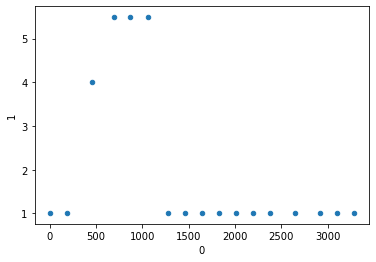

In [21]:
cartera = Cartera(acciones, bonos, derivados,'CLP', datetime.date(2019,2,1), cn, 60)

In [22]:
print(cartera.get_historicos_totales())

UF#0#AAA  UF#179#AAA  UF#454#AAA  UF#682#AAA  UF#860#AAA  UF#1042#AAA  \
0        1.0    1.034834    1.090730    1.139355    1.178818     1.220582   
1        1.0    1.034916    1.090947    1.139695    1.179254     1.221115   
2        1.0    1.034089    1.088749    1.136285    1.174808     1.215528   
3        1.0    1.033997    1.088491    1.135844    1.174157     1.214603   
4        1.0    1.033966    1.088376    1.135532    1.173744     1.214123   
5        1.0    1.033733    1.087788    1.134741    1.172811     1.213066   
6        1.0    1.033605    1.087457    1.134264    1.172176     1.212234   
7        1.0    1.033830    1.088048    1.135148    1.173333     1.213704   
8        1.0    1.033917    1.088278    1.135509    1.173803     1.214293   
9        1.0    0.994539    0.983576    0.971621    0.963504     0.955979   
10       1.0    0.993816    0.980192    0.970442    0.962845     0.955102   
11       1.0    0.994067    0.981719    0.972552    0.965440     0.958204   
12 

In [23]:
print(cartera.get_retornos_totales())

UF#0#AAA  UF#179#AAA  UF#454#AAA  UF#682#AAA  UF#860#AAA  UF#1042#AAA  \
0   0.000000    0.000000    0.000000    0.000000    0.000000     0.000000   
1   0.000097    0.000175    0.000296    0.000396    0.000467     0.000534   
2   0.000290   -0.000509   -0.001728   -0.002707   -0.003488    -0.004297   
3   0.000097    0.000007   -0.000140   -0.000292   -0.000458    -0.000664   
4   0.000097    0.000068   -0.000009   -0.000178   -0.000255    -0.000299   
5   0.000097   -0.000129   -0.000444   -0.000600   -0.000699    -0.000774   
6   0.000097   -0.000027   -0.000207   -0.000324   -0.000445    -0.000590   
7   0.000290    0.000508    0.000833    0.001069    0.001276     0.001502   
8   0.000097    0.000180    0.000308    0.000414    0.000497     0.000582   
9   0.000097   -0.038733   -0.101061   -0.155774   -0.197331    -0.239084   
10  0.000097   -0.000631   -0.003350   -0.001118   -0.000588    -0.000822   
11  0.000097    0.000350    0.001654    0.002269    0.002789     0.003340   
12 

In [24]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

nan
